## 3 AIS dataset process _ NEWS _ can be implementd (not part of present works) 

In [2]:
to_process_data_path = r'W:\Neeraj_thesis\version2_thesis\dataset\2019\generator_version_2_output_unifom_ts\data_2019_01_v2_uniform_ts_out.csv'
to_store_data_path = r'W:\Neeraj_thesis\version2_thesis\dataset\2019\generator_version_3_output_news_uniform_ts\data_2019_01_v3_news_uniform_ts_out.csv'
coast_points_path = r'W:\Neeraj_thesis\version2_thesis\dataset\coastline\oslo_fjord_coastline.csv'

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import figure
from matplotlib.colors import ListedColormap
from matplotlib import cm

from PIL import Image
import requests
import math
from scipy.interpolate import interp1d
import datetime
from datetime import datetime
import matplotlib.collections as colors

from math import radians, sin, cos, sqrt, atan2
from geopy.distance import geodesic
from geopy.distance import distance
from vincenty import vincenty
import haversine as hs
from geopy.distance import great_circle
from rtree import index
from shapely.geometry import Point, Polygon




#### Adding new feature _ coastal_points

In [3]:
coast_points = pd.read_csv(coast_points_path)
coast_points =  coast_points.drop(['Unnamed: 0'], axis=1).reset_index(drop = True)

In [4]:
coast_points = coast_points.drop_duplicates()


C:\Users\neerajm\AppData\Local\Temp\4\ipykernel_29376\4103876435.py:20: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x0000021632542610> has a label of '_child0' which cannot be automatically added to the legend.
  plt.legend(handles=[coast_points_plot, coast_reference_plot, origin_plot], loc='upper right')
C:\Users\neerajm\AppData\Local\Temp\4\ipykernel_29376\4103876435.py:20: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x0000021632542FA0> has a label of '_child2' which cannot be automatically added to the legend.
  plt.legend(handles=[coast_points_plot, coast_reference_plot, origin_plot], loc='upper right')


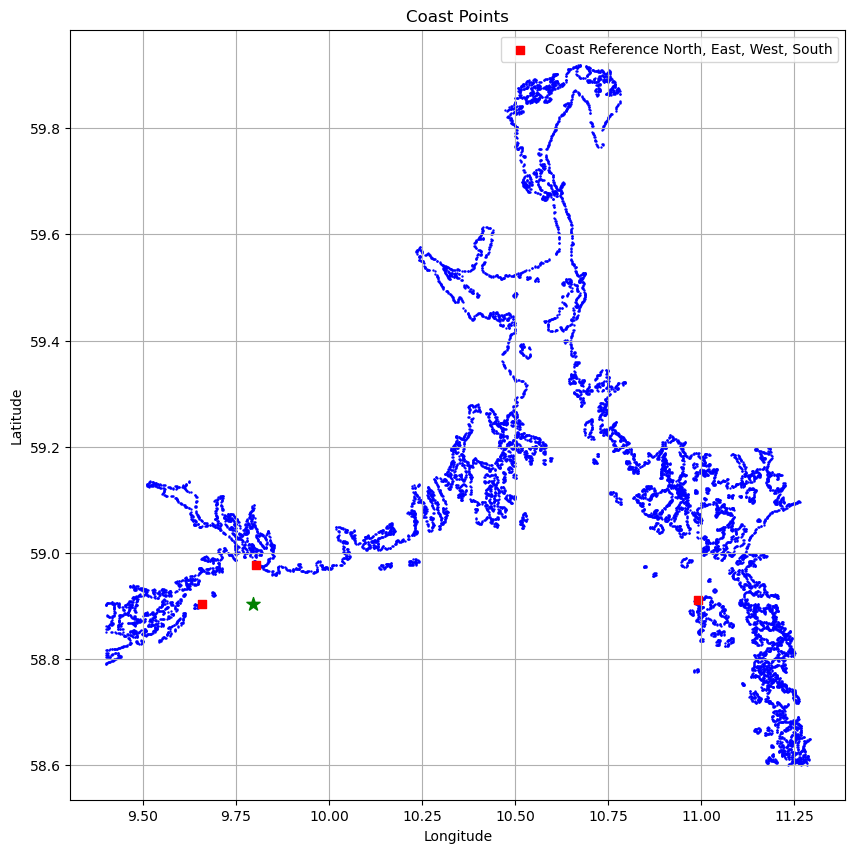

In [46]:
## For data exploratoin (visualization)
# #### Sample plot
# # Extracting lon and lat values
# lon = coast_points['lon']
# lat = coast_points['lat']

# lat_found = [58.904167, 58.910806, 58.977083]
# lon_found = [9.659111, 10.990861, 9.803333]

# origin_lat = [58.903207]
# origin_lon = [9.795204]

# plt.figure(figsize=(10, 10))
# coast_points_plot  = plt.scatter(lon, lat, s=.5, c='blue', label='Coast Points')
# coast_reference_plot  = plt.scatter(lon_found, lat_found, s=40, marker='s', c='red', label='Coast Reference (North, East, West, South)')
# origin_plot= plt.scatter(origin_lon, origin_lat, s=100, marker='*', c='green', label='Ship Position')  # Marking the origin coordinate with a star

# plt.legend(handles=[coast_points_plot, coast_reference_plot, origin_plot], loc='upper right')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Coast Points')
# plt.grid(True)
# plt.show()


In [644]:
ais_clean_v1 = pd.read_csv(to_process_data_path)

In [645]:
ais_clean_v2 = ais_clean_v1.copy()

In [649]:
def west_coast_value(coast_points_df, lat_value, lon_value):
    closest_distance = math.inf
    closest_coast_idx = None
    coast_points_df_west =  coast_points_df[coast_points_df['lon'] < lon_value]
    close_val_lat_s = [lat for lat in coast_points_df_west['lat'] if abs(lat - lat_value) <= .01]
    close_west_df = coast_points_df_west[coast_points_df_west['lat'].isin(close_val_lat_s)]
    
    if not close_west_df.empty:
        close_val_lon = [min(close_west_df['lon'], key=lambda x: abs(x - lon_value))]
        west_close_indexes_df = close_west_df[close_west_df['lon'].isin(close_val_lon)]
        
        closest_val_lat = min(west_close_indexes_df['lat'], key=lambda x: abs(x-lat_value))
        closest_val_lon = west_close_indexes_df.loc[west_close_indexes_df['lat'] == closest_val_lat, 'lon'].item()

        distance = round(hs.haversine((closest_val_lat, closest_val_lon), (lat_value, lon_value), unit='m'))

        if distance < closest_distance:
            closest_distance = distance
        else:
            pass
    else:
        pass
    return closest_distance 



In [650]:

ais_clean_v2['west_coast_distance'] = ais_clean_v2.apply(lambda row: west_coast_value(coast_points, row['lat'], row['lon']), axis=1)


In [652]:
def east_coast_value(coast_points_df, lat_value, lon_value):
    closest_distance = math.inf
    closest_coast_idx = None

    coast_points_df_east =  coast_points_df[coast_points_df['lon'] > lon_value]
    close_val_lat_s = [lat for lat in coast_points_df_east['lat'] if abs(lat - lat_value) <= .01]
    close_east_df = coast_points_df_east[coast_points_df_east['lat'].isin(close_val_lat_s)]
    
    if not close_east_df.empty:
        close_val_lon = [min(close_east_df['lon'], key=lambda x: abs(x - lon_value))]
        east_close_indexes_df = close_east_df[close_east_df['lon'].isin(close_val_lon)]
        closest_val_lat = min(east_close_indexes_df['lat'], key=lambda x: abs(x-lat_value))
        closest_val_lon = east_close_indexes_df.loc[east_close_indexes_df['lat'] == closest_val_lat, 'lon'].item()
        distance = round(hs.haversine((closest_val_lat, closest_val_lon), (lat_value, lon_value), unit='m'))
        if distance < closest_distance:
            closest_distance = distance
        else:
            pass
    else:
        pass
    return closest_distance 


In [653]:

ais_clean_v2['east_coast_distance'] = ais_clean_v2.apply(lambda row: east_coast_value(coast_points, row['lat'], row['lon']), axis=1)

In [654]:

def north_coast_value(coast_points_df, lat_value, lon_value):
    closest_distance = math.inf
    # closest_coast_idx = None

    coast_points_df_north =  coast_points_df[coast_points_df['lat'] > lat_value]
    close_val_lon_s = [lon for lon in coast_points_df_north['lon'] if abs(lon - lon_value) <= .01]
    close_north_df = coast_points_df_north[coast_points_df_north['lon'].isin(close_val_lon_s)]
    
    if not close_north_df.empty:
        close_val_lat = [min(close_north_df['lat'], key=lambda x: abs(x - lat_value))]
        north_close_indexes_df = close_north_df[close_north_df['lat'].isin(close_val_lat)]
        closest_val_lon = min(north_close_indexes_df['lon'], key=lambda x: abs(x-lon_value))
        closest_val_lat = north_close_indexes_df.loc[north_close_indexes_df['lon'] == closest_val_lon, 'lat'].item()
        distance = round(hs.haversine((closest_val_lat, closest_val_lon), (lat_value, lon_value), unit='m'))
        if distance < closest_distance:
            closest_distance = distance
        else:
            pass
    else:
        pass
    return closest_distance 



In [655]:
ais_clean_v2['north_coast_distance'] = ais_clean_v2.apply(lambda row: north_coast_value(coast_points, row['lat'], row['lon']), axis=1)


In [656]:

def south_coast_value(coast_points_df, lat_value, lon_value):
    closest_distance = math.inf

    coast_points_df_south =  coast_points_df[coast_points_df['lat'] < lat_value]  ## Creating a df of all coast co-ordinates south of the target 
    close_val_lon_s = [lon for lon in coast_points_df_south['lon'] if abs(lon - lon_value) <= .01] ## Identify all longitudes that lie in the 1.1km range (ie.+-1.1km longitudes of the target longitude )
    close_south_df = coast_points_df_south[coast_points_df_south['lon'].isin(close_val_lon_s)] ## Identify the dataset with the threshold longitudes 
    
    if not close_south_df.empty: ## If there is any df (ie. valid south longitude co-ordinate):
        close_val_lat = [min(close_south_df['lat'], key=lambda x: abs(x - lat_value))] ## For the accepted longitude co-ordinates find the closest latitude(S) to the target's latitude
        
        south_close_indexes_df = close_south_df[close_south_df['lat'].isin(close_val_lat)] ## Again: Identify the sub-set with those  idenified - closest latitudes
        closest_val_lon = min(south_close_indexes_df['lon'], key=lambda x: abs(x-lon_value)) ## Again: Among the closest latitude(S) identify the co-ordinate with the closest longitude  
        closest_val_lat = south_close_indexes_df.loc[south_close_indexes_df['lon'] == closest_val_lon, 'lat'].item() ## Idenfity the closest co-ordinates -> Latitude

        distance = round(hs.haversine((closest_val_lat, closest_val_lon), (lat_value, lon_value), unit='m')) ## Calculate the distance between the coast_closest (lat,lon) and the target (lat,long) 
        if distance < closest_distance: 
            closest_distance = distance
        else:
            pass
    else:
        pass
    return closest_distance ## Return the distance of the shore/landmass to the south





In [657]:
ais_clean_v2['south_coast_distance'] = ais_clean_v2.apply(lambda row: south_coast_value(coast_points, row['lat'], row['lon']), axis=1)

In [659]:
ais_clean_v3 = ais_clean_v2.copy()

In [660]:
def create_coast_index(coast_df):
    idx = index.Index()
    for i, row in coast_df.iterrows():
        lat, lon = row['lat'], row['lon']
        idx.insert(i, (lon, lat, lon, lat))
    return idx

def nearest_distance_to_coast_rtree(lat, lon, coast_df, coast_index):
    vessel_point = (lat, lon)
    min_distance = float('inf')

    for coast_idx in coast_index.nearest((lon, lat, lon, lat)):
        coast_point = (coast_df.at[coast_idx, 'lat'], coast_df.at[coast_idx, 'lon'])
        distance = great_circle(vessel_point, coast_point).meters

        if distance < min_distance:
            min_distance = distance

    return min_distance
# create an R-tree index for the coast data
coast_index = create_coast_index(coast_points)
# calculate the nearest distance to coast for each row in the AIS dataset
ais_clean_v3['nearest_distance_to_coast'] = ais_clean_v3.apply(lambda row: nearest_distance_to_coast_rtree(row['lat'], row['lon'], coast_points, coast_index), axis=1)
# ais_data.to_csv('ais_data_with_nearest_distance_to_coast_rtree.csv', index=False)


In [661]:
## Not mandatory - as we would be using standardized data when training. 
ais_clean_v3['NDC_nm'] = (ais_clean_v3['nearest_distance_to_coast']/1852).round(3)



In [662]:
ais_clean_v3 =  ais_clean_v3.drop(['nearest_distance_to_coast'], axis=1).reset_index(drop = True)

#### Adding new feature: In_TSS (transit corridor/ traffic separation scheme)


In [664]:
# Moving out
# # Outer to inner: 
# lat_1,lon_1 = 59.15952, 10.630281
# lat_2, lon_2 = 59.434427, 10.538721
# lat_3, lon_3 = 59.514555, 10.565243
# lat_4, lon_4 = 59.562723, 10.609274

# # Moving in 
# # Inner to outer:
# lat_5, lon_5 = 59.562767, 10.648413
# lat_6, lon_6 = 59.558244, 10.647554 
# lat_7, lon_7 = 59.514468, 10.60009
# lat_8, lon_8 = 59.434471, 10.567045
# lat_9, lon_9 = 59.162864, 10.668755


## With margin:
lat_1,lon_1 = 59.158112, 10.619316
lat_2, lon_2 = 59.322287, 10.550737

lat_3, lon_3 = 59.334021, 10.541897
lat_4, lon_4 = 59.363426, 10.548849
lat_5, lon_5 = 59.427574, 10.528078
lat_6, lon_6 = 59.435038, 10.520954 

lat_7, lon_7 = 59.509373, 10.553484
lat_8, lon_8 = 59.514468, 10.562239
lat_9, lon_9 = 59.521304, 10.560436
lat_10, lon_10 = 59.550111, 10.586185

lat_11,lon_11 = 59.562202, 10.605755


# Moving in 
# Inner to outer:
lat_12,lon_12 = 59.56281, 10.64867
lat_13,lon_13 = 59.555548, 10.649958
lat_14,lon_14 = 59.548023, 10.647039
lat_15,lon_15 = 59.514032, 10.611248
lat_16,lon_16 = 59.438748, 10.582409
lat_17,lon_17 = 59.434732, 10.575714
lat_18,lon_18 = 59.164624, 10.68532



In [665]:

# define the polygon vertices as a list of (latitude, longitude) pairs
polygon_vertices = [(lat_1, lon_1), (lat_2, lon_2), (lat_3, lon_3),(lat_4, lon_4), (lat_5, lon_5), (lat_6, lon_6),(lat_7, lon_7), (lat_8, lon_8), (lat_9, lon_9), (lat_10, lon_10), (lat_11, lon_11), (lat_12, lon_12), (lat_13, lon_13), (lat_14, lon_14), (lat_15, lon_15), (lat_16, lon_16), (lat_17, lon_17), (lat_18, lon_18)]


polygon = Polygon(polygon_vertices)

for_tss_group = ais_clean_v3.groupby('new_short_voyage_id')
sub_dfs = []
count = 0

in_tss = 1 # initialize the new_short_voyage_id
not_in_tss = 0

for id, data_frame in for_tss_group:
    
    count += 1
    print(count)

    data_frame = data_frame.reset_index(drop=True)
    sub_dfs_temp = []

    start_index = 0
  

    # loop through the rows in the DataFrame
    for index, row in data_frame.iterrows():
        lat, lon = row['lat'], row['lon']
        point = Point(lat, lon)

        if polygon.contains(point):
            data_frame.at[index, 'In_TSS'] = 1
        else:
            data_frame.at[index, 'In_TSS'] = 0

    sub_dfs_temp.append(data_frame)

    sub_dfs += sub_dfs_temp

# concatenate all the sub-DataFrames into a single DataFrame
ais_clean_v3 = pd.concat(sub_dfs, ignore_index=True)




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


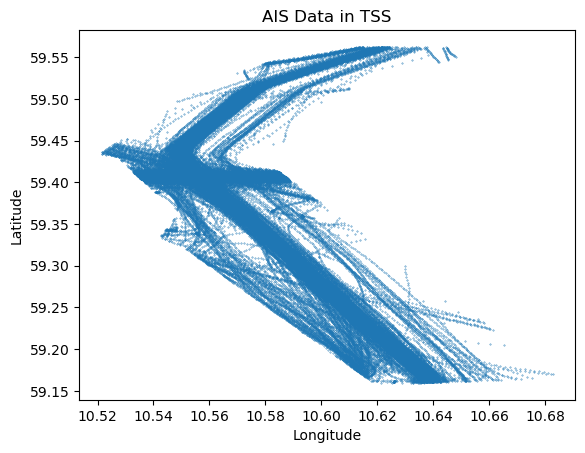

In [666]:
## For data exploratoin (visualization)
import matplotlib.pyplot as plt

# Filter the AIS data where In_TSS is 1
ais_in_tss = ais_clean_v3[ais_clean_v3['In_TSS'] == 1]

# Create a scatter plot of latitude and longitude
plt.scatter(ais_in_tss['lon'], ais_in_tss['lat'], s=0.1)

# Set plot title and axis labels
plt.title('AIS Data in TSS')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [668]:
#### Vessel belong to TSS TRANSIT if number of timesteps in TSS > 10 minutes
ais_clean_v4 = ais_clean_v3.copy()
# ## entry
# lat_low = 59.175225 # lon = 10.64395
# ## exit
# lat_high = 59.619853 # lon = 10.626526
## entry and exit with margin:
lat_low = 59.19712 # , 10.63674
lat_high = 59.548589# , 10.61451

## breadth of TSS: lat/lon left: 59.434471/ 10.538549 ; lat/lon right: 59.434514/ 10.566788

voy_group_data = ais_clean_v4.groupby('new_short_voyage_id')

voy_dfs = []
count = 0

for id, voy_df in voy_group_data:
    count += 1
    print(count)
    
    # check if all In_TSS values are 1 for latitude in range (x, y)
    if (voy_df['lat'].min() < lat_low) & (voy_df['lat'].max() > lat_high):
        if voy_df[(voy_df['lat'] >= lat_low) & (voy_df['lat'] <= lat_high)]['In_TSS'].all() == 1:
            voy_df.loc[:, 'Vessel_TSS'] = 1
        else:
            pass
        
    else:
        voy_df.loc[:,'Vessel_TSS'] = 0

    # append the modified group dataframe to the list
    voy_dfs.append(voy_df)

# concatenate the individual group dataframes into one net dataframe
ais_clean_v4 = pd.concat(voy_dfs)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [669]:
# filter the dataframe to include only voyages where Vessel_TSS is 1
tss_voyages = ais_clean_v4[ais_clean_v4['Vessel_TSS'] == 1]
# count the number of unique short voyage IDs in the filtered dataframe
num_tss_voyages = tss_voyages['new_short_voyage_id'].nunique()

print("Number of unique short voyage IDs with Vessel_TSS as 1:", num_tss_voyages)


Number of unique short voyage IDs with Vessel_TSS as 1: 166


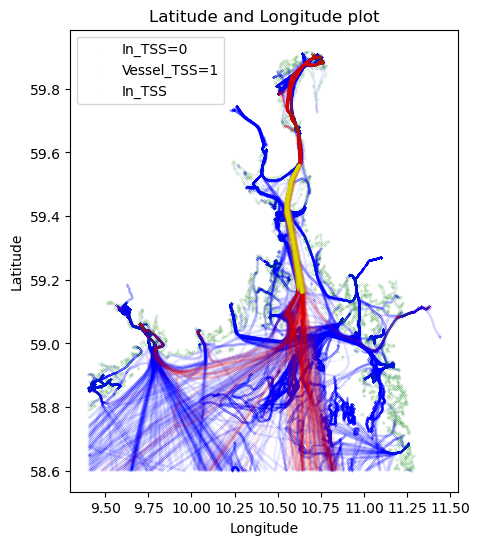

In [670]:
import matplotlib.pyplot as plt

# Get the indices where In_TSS is 0 or 1
idx_0 = ais_clean_v4['Vessel_TSS'] == 0
idx_1 = ais_clean_v4['Vessel_TSS'] == 1
# idx_2 = ais_clean_v4['In_TSS'] == 1
idx_2 = (ais_clean_v4['In_TSS'] == 1) & (ais_clean_v4['Vessel_TSS'] == 1)

plt.figure(figsize=(5, 6))
plt.scatter(ais_clean_v4['lon'][idx_0], ais_clean_v4['lat'][idx_0], color='blue', label='In_TSS=0', s = 0.0002)
plt.scatter(ais_clean_v4['lon'][idx_1], ais_clean_v4['lat'][idx_1], color='red', label='Vessel_TSS=1', s = 0.0002)
plt.scatter(ais_clean_v4['lon'][idx_2], ais_clean_v4['lat'][idx_2], color='yellow', label='In_TSS', s = 0.0002)
plt.scatter(coast_points['lon'],coast_points['lat'], color = 'green', s=0.0008)

plt.title('Latitude and Longitude plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [671]:
## Saving the new dataset with 6 key features ('lat', 'lon', 'sog', 'cog_sin', 'cog_cos', 'NDC_nm', in_TSS, Vessel_TSS  )

ais_clean_v4.to_csv(to_store_data_path, index=False)